In [2]:
from tensorflow import keras
from keras.layers import StringLookup

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pathlib import Path
import os

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Configuration

In [4]:
BASEDIR = Path(os.getcwd())
DESTDIR = BASEDIR / "etl_output"
MODLDIR = BASEDIR / "saved_models"
DATASET = str(DESTDIR / "words.dts")
model_name  = str(MODLDIR / "hr_base_100epochs.h5")

In [5]:
image_width = 128
image_height = 32
batch_size = 64

max_len = 21
padding_token = 99
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
characters = [
	'!', '"', '#', '&', "'", '(', ')', '*', '+', ',',
	'-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
	'7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D',
	'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
	'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
	'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
	'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
	's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


## Load data

In [6]:
def split_dataset(ds: tf.data.Dataset, left_frac = 0.5):
    N = len(ds)
    L = int(left_frac * N)
    ds = ds.shuffle(N)
    return ds.take(L), ds.skip(L).take(N - L)

dataset = tf.data.Dataset.load(DATASET)
train_ds, dataset = split_dataset(dataset, 0.9)
validation_ds, test_ds = split_dataset(dataset, 0.5)

In [7]:
len(train_ds), len(validation_ds), len(test_ds)

(1181, 66, 66)

In [8]:
def pad_resize_transpose(image, img_size):
    image = tf.image.resize(image, size=img_size, preserve_aspect_ratio=True)
    padding = np.array(img_size) - np.array(image.shape)[:2]
    W, H = padding // 2
    w, h = padding % 2

    image = tf.pad(
        image,
        paddings=[
            [W, W+w],
            [H, H+h],
            [0, 0]
        ]
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = pad_resize_transpose(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [10]:
def plot_test_samples(images, labels):
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        try:
            indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
            label = tf.strings.reduce_join(num_to_char(indices))
            label = label.numpy().decode("utf-8")
        except: ...

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

In [11]:
model = keras.models.load_model(model_name, compile=False)
model.compile()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

## Test predictions

2/2 [==============================] - 2s 151ms/step


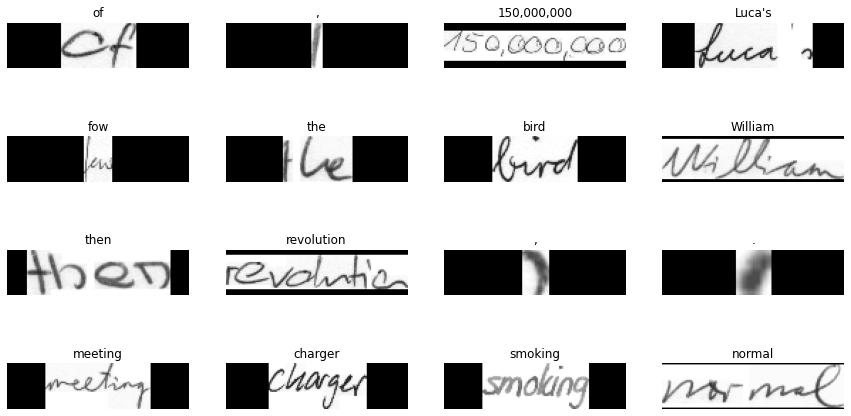

In [12]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


for batch in test_ds.take(1):
    images = batch["image"]
    preds = prediction_model.predict(images)
    labels = decode_batch_predictions(preds)

    plot_test_samples(images, labels)

In [113]:
from google.colab import files

# plt.imsave("this.png", x, cmap="gray")
# files.download("this.png")

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = pad_resize_transpose(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def upload_and_predict():
    img = files.upload()
    name = list(img.keys())[0]
    x = preprocess_image(name)

    preds = prediction_model.predict(tf.reshape([x], (1, 128, 32, 1)))
    label = decode_batch_predictions(preds)

    img = tf.io.read_file(name)
    img = tf.image.decode_png(img, 1)
    plt.imshow(img, cmap="gray")
    plt.title(label[0])


Saving me.png to me (9).png
1/1 [==============================] - 0s 37ms/step


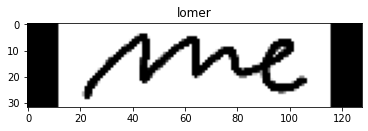

In [114]:
upload_and_predict()

Saving grayscale.png to grayscale.png
1/1 [==============================] - 0s 34ms/step


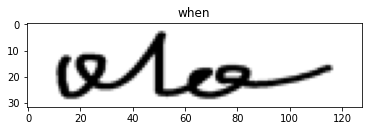

In [115]:
upload_and_predict()

Saving well.png to well.png
1/1 [==============================] - 0s 40ms/step


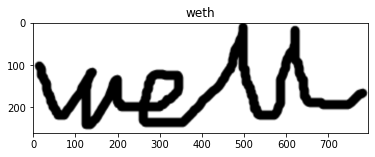

In [116]:
upload_and_predict()

Saving well2.png to well2.png
1/1 [==============================] - 0s 35ms/step


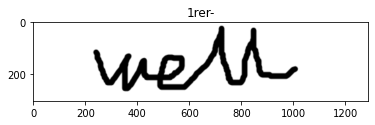

In [117]:
upload_and_predict()

Saving 8.png to 8.png
1/1 [==============================] - 0s 32ms/step


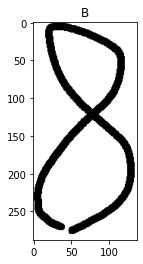

In [118]:
upload_and_predict()

Saving How.png to How.png
1/1 [==============================] - 0s 64ms/step


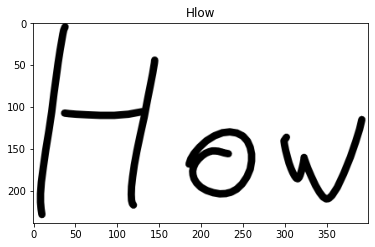

In [119]:
upload_and_predict()

Saving L.png to L.png
1/1 [==============================] - 0s 38ms/step


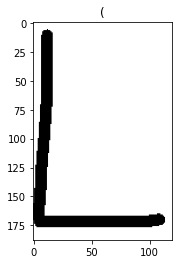

In [121]:
upload_and_predict()

Saving a.png to a.png
1/1 [==============================] - 0s 32ms/step


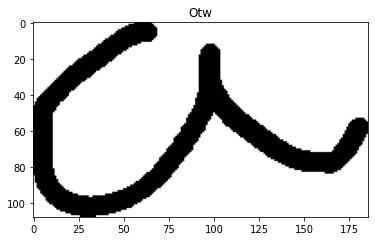

In [124]:
upload_and_predict()

Saving a2.png to a2.png
1/1 [==============================] - 0s 38ms/step


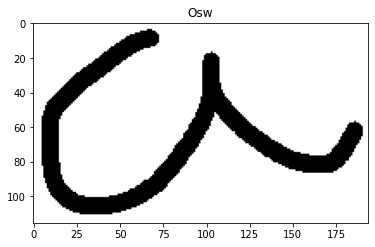

In [125]:
upload_and_predict()